## 基于SMO算法实现SVM

In [13]:
import numpy as np
from matplotlib import pyplot as plt


class LinearKernel:  # 线性核函数

    def __call__(self, a: np.ndarray, b: np.ndarray):
        return np.sum(a * b, axis=-1) # 对最内轴进行求和，即行向量内积


class PolyKernel:  # 多项式核函数

    def __call__(self, a: np.ndarray, b: np.ndarray):
        return (np.sum(a * b, axis=-1) + 1)**2 # 公式(7.88)


class RBFKernel:  # 高斯核函数

    def __init__(self, sigma):
        self.divisor = 2 * sigma**2

    def __call__(self, a: np.ndarray, b: np.ndarray):
        return np.exp(-np.sum((a - b)**2, axis=-1) / self.divisor) # 公式(7.90)


class SVM:
    """
    Support Vector Machines(支持向量机)
    """

    def __init__(self, kernel="linear", C=1.0, iterations=100, tol=1e-3, sigma=1.0):
        """
        Args:
            kernel (str, optional): 核函数. Defaults to 'linear'.
            C (float, optional): 惩罚因子. Defaults to 1.0.
            iterations (int, optional): 最大迭代次数. Defaults to 100.
            tol (float, optional): 绝对误差限. Defaults to 1e-3.
            sigma (float, optional): 高斯核函数的sigma. Defaults to 1.0.
        """
        assert kernel in ["linear", "poly", "rbf"]

        if kernel == "linear":
            self.K = LinearKernel()  # 线性核函数
        elif kernel == "poly":
            self.K = PolyKernel()  # 多项式核函数
        elif kernel == "rbf":
            self.K = RBFKernel(sigma)  # 径向基核函数

        self.C, self.iterations, self.tol, self.alpha, self.b = C, iterations, tol, None, 0.0
        self.X, self.y = None, None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X, self.y = X, y

        # 拉格朗日乘子，长度为样本个数，初始值为1
        self.alpha = np.ones([len(X)])
        for _ in range(self.iterations):
            # 此次迭代缓存的误差
            E = np.array([self.__E(i) for i in range(len(X))])

            # 7.4.2 变量的选择方法
            # 外层循环，寻找第一个alpha
            for i1 in range(len(X)):
                if self.__satisfy_kkt(i1): #满足KKT条件
                    continue

                # 计算误差(不使用E缓存)
                E1 = self.__E(i1)
                # 内层循环，寻找第二个alpha
                i2 = np.argmin(E) if E1 > 0 else np.argmax(E) # 大于0则选择最小，小于0选择最大的
                if i1 == i2:
                    continue
                E2 = self.__E(i2)

                # 7.4.1 两个变量二次规划的求解方法
                x1, x2, y1, y2 = X[i1], X[i2], y[i1], y[i2]
                alpha1, alpha2 = self.alpha[i1], self.alpha[i2]
                k11, k22, k12 = self.K(x1, x1), self.K(x2, x2), self.K(x1, x2)

                # 计算剪切范围
                if y1 * y2 < 0:
                    L = max(0, alpha2 - alpha1)
                    H = min(self.C, self.C + alpha2 - alpha1)
                else:
                    L = max(0, alpha1 + alpha2 - self.C)
                    H = min(self.C, alpha1 + alpha2)

                # 公式(7.107)
                eta = k11 + k22 - 2 * k12
                if eta <= 0:
                    continue

                # 计算新alpha
                # 公式(7.106), (7.108)
                alpha2_new = np.clip(alpha2 + y2 * (E1 - E2) / eta, L, H)
                # 公式(7.109)
                alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new)

                # 计算新b
                alpha2_delta, alpha1_delta = alpha2_new - alpha2, alpha1_new - alpha1
                # 公式(7.115)
                b1_new = -E1 - y1 * k11 * alpha1_delta - y2 * k12 * alpha2_delta + self.b
                # 公式(7.116)
                b2_new = -E2 - y1 * k12 * alpha1_delta - y2 * k22 * alpha2_delta + self.b

                # 更新参数
                self.alpha[i1] = alpha1_new
                self.alpha[i2] = alpha2_new
                if 0 < alpha1_new < self.C:
                    self.b = b1_new
                elif 0 < alpha2_new < self.C:
                    self.b = b2_new
                else:
                    self.b = (b1_new + b2_new) / 2

                # 更新误差缓存
                E[i1] = self.__E(i1)
                E[i2] = self.__E(i2)

    # 公式(7.94)
    def predict(self, X: np.ndarray):
        y_pred = np.array([self.__g(x) for x in X])
        return np.where(y_pred > 0, 1, -1)  # 将(-\infinity, \infinity)之间的分布转为{-1, +1}标签

    def values(self, X: np.ndarray):
        return np.array([self.__g(x) for x in X])

    @property
    def support_vectors(self):  # 支持向量
        return self.X[self.alpha > 0]

    # 公式(7.104)
    def __g(self, x):  # g(x) =\sum_{i=0}^N alpha_i y_i \kappa(x_i, x)
        return np.sum(self.alpha * self.y * self.K(self.X, x)) + self.b

    # 公式(7.105)
    def __E(self, i):  # E_i = g(x_i) - y_i
        return self.__g(self.X[i]) - self.y[i]

    # 公式(7.111) ~ (7.113)
    def __satisfy_kkt(self, i):  # 是否满足KKT条件
        g_i, y_i = self.__g(self.X[i]), self.y[i]
        if np.abs(self.alpha[i]) < self.tol:
            return g_i * y_i >= 1
        if np.abs(self.alpha[i]) > self.C - self.tol:
            return g_i * y_i <= 1
        return np.abs(g_i * y_i - 1) < self.tol


## 测试

### 线性支持向量机

SMO linear kernel accuracy: 0.84


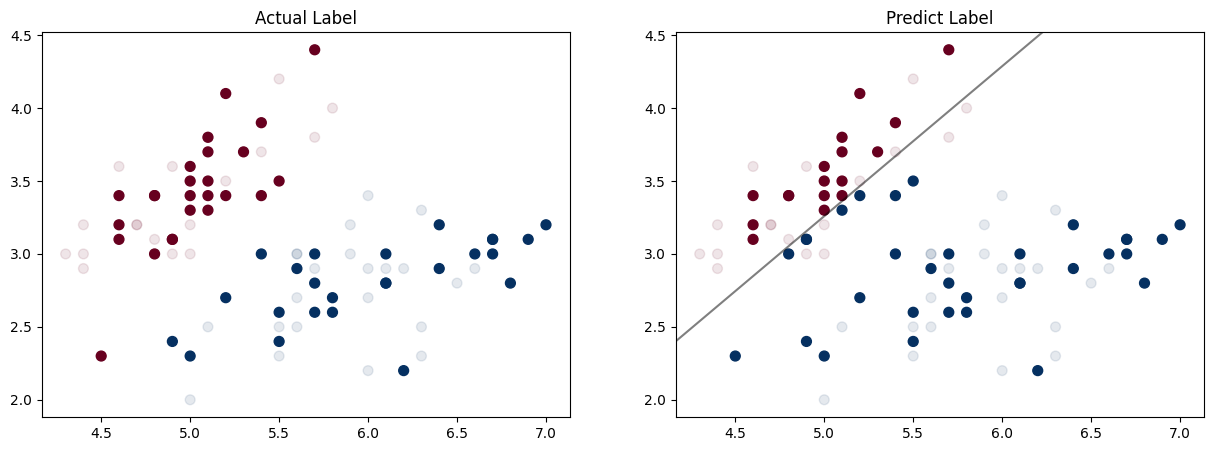

In [14]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def load_linear_data(test_size_perc):
    iris = sns.load_dataset("iris")
    # 取出'sepal_length'，'sepal_width'和'species'，前100个数据，前50个'species'是'setosa'，后50个'species'是'versicolor'
    data = np.array(iris.iloc[:100, [0, 1, -1]])
    # 第一维度全部取出(100行)，第二维度取出第一个列，到倒数第二个列
    X = data[:, :-1]
    # 二分类'species'标签，'setosa'值为-1，'versicolor'值为1
    y = np.array([1 if s == 'versicolor' else -1 for s in data[:, -1]])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size_perc)
    return X_train, X_test, y_train, y_test

def plot_decision_plan(model, ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.values(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

def test_linear_svm():
    X_train, X_test, y_train, y_test = load_linear_data(0.5)
    model_linear = SVM(kernel="linear", C=1000, iterations=100)
    model_linear.fit(X_train, y_train)
    y_pred = model_linear.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("SMO linear kernel accuracy: " + str(accuracy))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Actual Label")
    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu')

    ax[1].set_title("Predict Label")
    ax[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=50, cmap='RdBu')

    plot_decision_plan(model_linear, ax[1])


test_linear_svm()

### 多项式核支持向量机

SMO poly kernel accuracy: 0.804


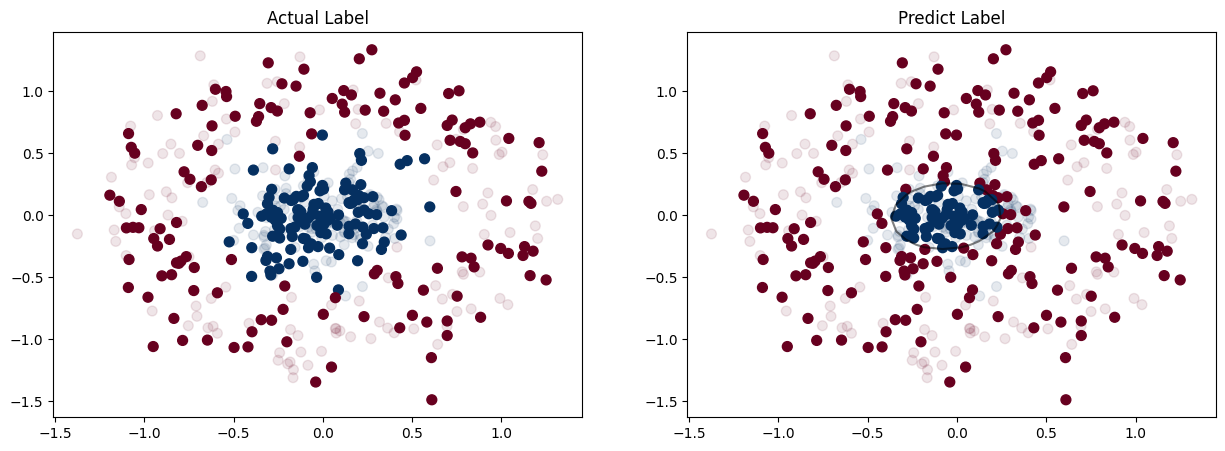

In [15]:
from sklearn.datasets import make_circles

def load_nonlinear_data(test_size_perc):
    size = 500
    test_size = int(size * test_size_perc)
    X, y = make_circles(size, factor=.1, noise=.2)
    X_train = X[:-test_size]
    y_train = 2 * y[:-test_size] - 1 # convert to 1 or -1
    X_test = X[-test_size:]
    y_test = 2 * y[-test_size:] - 1 # convert to 1 or -1
    return X_train, X_test, y_train, y_test

def test_poly_svm():
    X_train, X_test, y_train, y_test = load_nonlinear_data(0.5)
    model = SVM(kernel="poly", C=1000, iterations=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("SMO poly kernel accuracy: " + str(accuracy))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Actual Label")
    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu')

    ax[1].set_title("Predict Label")
    ax[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=50, cmap='RdBu')
    plot_decision_plan(model, ax[1])

test_poly_svm()

### 高斯核支持向量机

SMO RBF kernel accuracy: 0.98


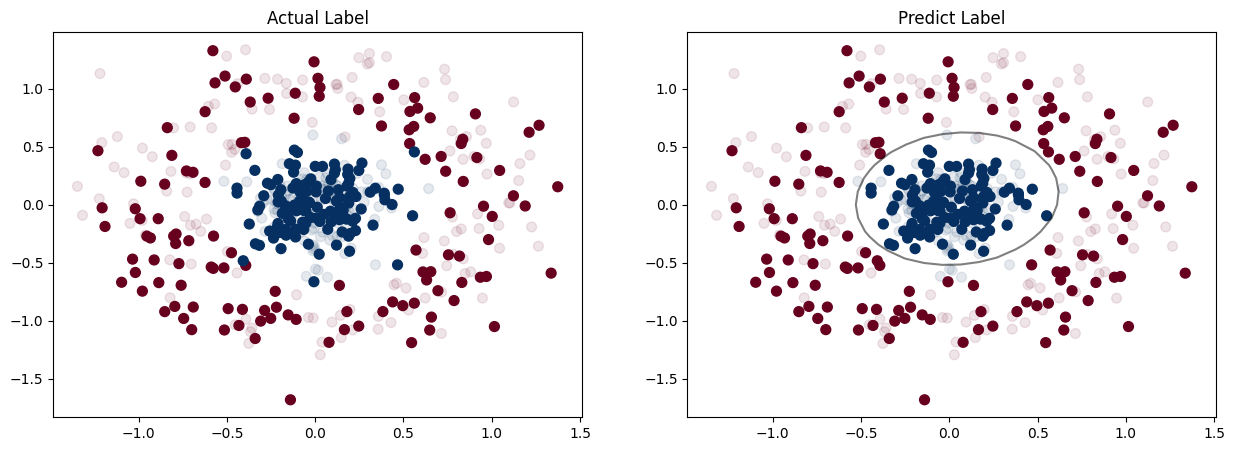

In [16]:
def test_rbf_svm():
    X_train, X_test, y_train, y_test = load_nonlinear_data(0.5)
    model = SVM(kernel="rbf", C=100, sigma=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("SMO RBF kernel accuracy: " + str(accuracy))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Actual Label")
    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu')

    ax[1].set_title("Predict Label")
    ax[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.1, cmap='RdBu')
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=50, cmap='RdBu')
    plot_decision_plan(model, ax[1])

test_rbf_svm()